In [5]:
"""
This notebook creates a Bayesian model for displaying the posterior distribution of bike ride 
durations.
"""

import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import lognorm
from sklearn.model_selection import train_test_split

# File name for the final model results
MODEL_RESULTS_FILE = '../models/duration_model_results.nc'

In [6]:
# Load in the data
df_bike = pd.read_pickle("../data/indego_bike_data.pkl")
print(df_bike.head())

       trip_id  duration           start_time             end_time  \
0  144361832.0      12.0  2017-07-01 00:04:00  2017-07-01 00:16:00   
1  144361829.0      31.0  2017-07-01 00:06:00  2017-07-01 00:37:00   
2  144361830.0      15.0  2017-07-01 00:06:00  2017-07-01 00:21:00   
3  144361831.0      15.0  2017-07-01 00:06:00  2017-07-01 00:21:00   
4  144361828.0      30.0  2017-07-01 00:07:00  2017-07-01 00:37:00   

   start_station  start_lat  start_lon  end_station    end_lat    end_lon  \
0         3160.0  39.956619 -75.198624       3163.0  39.949741 -75.180969   
1         3046.0  39.950119 -75.144722       3101.0  39.942951 -75.159554   
2         3006.0  39.952202  -75.20311       3101.0  39.942951 -75.159554   
3         3006.0  39.952202  -75.20311       3101.0  39.942951 -75.159554   
4         3046.0  39.950119 -75.144722       3101.0  39.942951 -75.159554   

   ... plan_duration  trip_route_category passholder_type bike_type  \
0  ...          30.0              One Way    

The idea of Bayesian modeling is best explained with an example. Say I want to find the average of a
particular variable, to get a broad sense of what that variable centers around. For this notebook, I
want to focus on the bike duration. Well, then one can simply get a dataset of all the bike ride
durations for all the bike rides in our data, and then get the numerical average. 

The issue with this however, is that there are probably a few factors that affect bike ride 
duration. The simple numerical average will probably not be super accurate since it is impacted by
many factors, and the average would muddle such relationships from a single metric. Instead, it is
likely that there is some kind of probability distribution for such a variable, and estimating this
would lead to more impactful answers. 

But even just plotting a histogram is not as rigorous. There needs to be a way to properly define
a formal probability distribution with.

This is done with the Bayesian framework. More explanation can be found online, but simply, the idea
is that one has some prior knowledge of the distribution to go off of. We also have some data of the
variable to focus on. Based on Bayes' theorem listed below (which is the fundamentals of conditional
probability), this prior and "likelihood" (the data) can be combined to perform a posterior
distribution, which is the probability distribution based on both things.

$$
p(\theta \mid \mathcal{D}) = \frac{p(\mathcal{D} \mid \theta) \, p(\theta)}{p(\mathcal{D})}
$$
where $$\theta$$ represents the variable to try and get a distribution of, and $$\mathcal{D}$$ 
represents the actual data.

In simplier terms, with some math based on Bayesian statistics, one can have some belief on some 
data, and update that belief based on empirical data to get a more accurate answer and quantify the
uncertainty by getting a range of values with this. Note that this process could be done multiple 
times, but for the sake of this task, I only do it once since one iteration is accurate enough.

Unfortunately, for bike ride duration, I have no idea on what it could be. But, there is an easy
workaround. I can randomly split the data and get a very small randomized subset, to view a 
histogram of the distribution, and to get the rough mean of the bike duration. I can then pass in 
this information on the corresponding larger randomized subset and build a Bayesian model with this
information (this avoids double counting data, which would basically be "cheating" - it would not 
make sense to do this process if I use the same data to get my prior information).

In [7]:
# Split data into a 5% "prior-informing" set and a 95% "model-fitting" set
# train_test_split splits into two sets; call the smaller one 'prior_data'
prior_data, model_data = train_test_split(df_bike["duration"], test_size=0.95, random_state=42)

# NOTE: there are some severe outliers (e.g. some rides lasting over 1000 minutes), so I filter
# those out. From even more prior knowledge, I know that there are some legitimate rides that last
# hundreds of minutes, which is why the upper bound is not lower.
prior_data = prior_data[prior_data < 1000]
model_data = model_data[model_data < 1000]

# NOTE: The combined dataset from all the years has over 7 million rows. Building the model later 
# will easily run out of RAM with all that data, so I do a random sample of 500k rows. I would 
# likely hit diminshing returns with more data anyway.
model_data_sample = model_data.sample(n=500000, random_state=42)

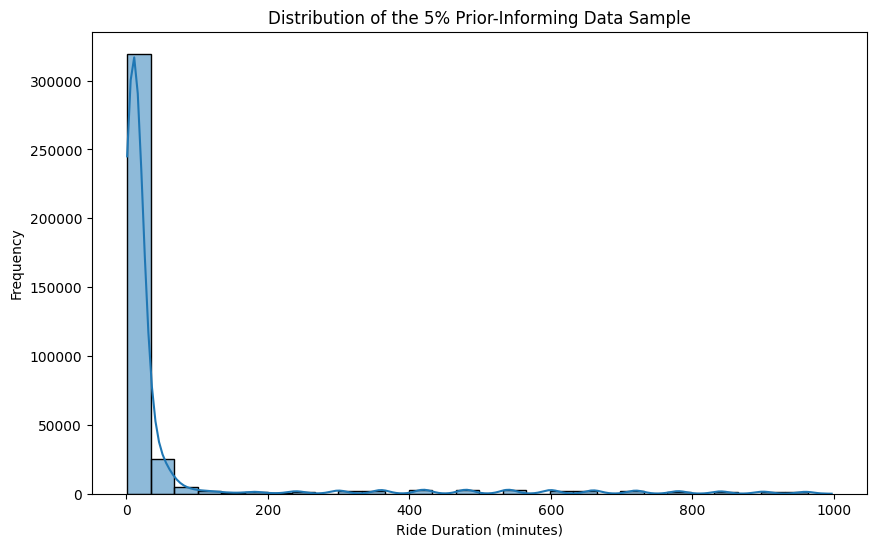

In [8]:
# Visualize the prior data
plt.figure(figsize=(10, 6))
sns.histplot(prior_data, bins=30, kde=True)
plt.title('Distribution of the 5% Prior-Informing Data Sample')
plt.xlabel('Ride Duration (minutes)')
plt.ylabel('Frequency')
plt.show()

It's clear that ride duration is heavily skewed right, which is not too surprising. Most rides are
under ~30 minutes. I choose that this is likely a log-normal distribution (though a gamma 
distribution is also a valid option, but I'm sticking wtih log-normal).

Now, I need to find the mu and sigma parameters of this log normal distribution.

In [9]:
# Get the natural logarithm of the data
log_prior_data = np.log(prior_data)
# Calculate the mean and standard deviation of the log-transformed data
estimated_mu = log_prior_data.mean()
estimated_sigma = log_prior_data.std()
print(f"Estimated mu: {estimated_mu}, Estimated sigma: {estimated_sigma}")

Estimated mu: 2.6649470142028893, Estimated sigma: 1.2933510788893074


Now, I have the neccessary prior information to build a PyMC model.

In [10]:
with pm.Model() as duration_model:
    # --- Priors ---
    # NOTE: The priors are centered on the parameters estimated from the 5% data sample. They have
    # their own independent distributions, which are about Normal for mu and HalfNormal for sigma
    mu = pm.Normal('mu', mu=estimated_mu, sigma=1.0)
    # Sigma has to be positive, so a HalfNormal distribution is used
    # to ensure it is constrained to positive values
    sigma = pm.HalfNormal('sigma', sigma=estimated_sigma)

    # --- Likelihood ---
    # Tell PyMC not to save the log-likelihood data to keep the model file size small
    idata_kwargs = {"log_likelihood": False}
    # The model assumes the observed data (95% split) follows a Log-Normal
    # distribution with the estimated parameters
    y_obs = pm.LogNormal(
        'y_obs',
        mu=mu,
        sigma=sigma,
        observed=model_data_sample.values,
    )

    # --- MCMC Sampling ---
    print("Running MCMC sampler...")
    # Spent 1000 tuning steps to allow the sampler to adapt
    # and then sample 2000 steps from the posterior distribution
    idata = pm.sample(2000, tune=1000, cores=12, progressbar=True, idata_kwargs=idata_kwargs)
    print("Sampling complete.")

# Save the final results to a file for later use
print("\n--- Saving Model Results ---")
idata.to_netcdf(MODEL_RESULTS_FILE)
print(f"Model results saved to {MODEL_RESULTS_FILE}")

Initializing NUTS using jitter+adapt_diag...


Running MCMC sampler...


Multiprocess sampling (12 chains in 12 jobs)
NUTS: [mu, sigma]


c:\Users\kevin\OneDrive\Documents\Python\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 12 chains for 1_000 tune and 2_000 draw iterations (12_000 + 24_000 draws total) took 192 seconds.


Sampling complete.

--- Saving Model Results ---
Model results saved to ../models/duration_model_results.nc


The main final step is to view a summary of the model, to validate that it was built correctly.

In [11]:
# Generate the summary table
summary_df = az.summary(idata)
# Print the summary
print(summary_df)

        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu     2.665  0.002   2.662    2.668        0.0      0.0   24323.0   18430.0   
sigma  1.296  0.001   1.293    1.298        0.0      0.0   24876.0   18418.0   

       r_hat  
mu       1.0  
sigma    1.0  


Let me break down what each column in this summary dataframe means:
`r_hat`
- The Gelman-Rubin statistic, which is the most important diagnostic for checking if the model's 
different MCMC chains have converged to the same answer. 
- This value should be close to 1.0 for
convergence, which is seen here, so that's good. If this was lower that would raise concerns that
something went wrong with the model.

`ess_bulk` and `ess_tail`
- Effective Sample Size. This estimates how many truly independent samples are contained in the
posterior distribution. Since MCMC samples can be correlated with each other, the ESS is often 
lower than the total number of draws. 
- Higher is better. Low values (e.g. under a few hundred) 
suggest the sampler was inefficient and struggled to explore the distribution, so the higher values 
here are good.

`mean`
- The average value of all the samples in the posterior distribution. This is the single best point 
estimate for the parameters of the proposed log-normal distribution.

`sd`
- The standard deviation of the posterior distribution. This measures the uncertainty in the estimate.

`hdi_3%` and `hdi_97%`
- The boundaries of the 94% Highest Density Interval (HDI). This is the Bayesian credible interval. 
It means there is a 94% probability that the true value of the parameter lies within this range. 
The boundaries here are very narrow so this indicates a very good estimate.

`mcse_mean` and `mcse_sd`
- The Monte Carlo Standard Error for the mean and standard deviation. This estimates the simulation 
error introduced by the fact that MCMC is a random process (which does multiple iterations and 
should eventually converge, as seen in the earlier results). 
- These numbers should be very small 
compared to the posterior sd, which indicates that the simulation error is negligible and the 
results are stable (and given that they are basically 0, this is met). I'll probably bring up
Monte Carlo chains in a future notebook for a more in depth explanation.

Overall, the Bayesian model that was fit was very good! Further work could build multiple models 
and then compare them with different Bayesian metrics, but given how good the results are in the 
summary dataframe, I'll keep this model. Below is a rough visual of the final posterior 
distribution.

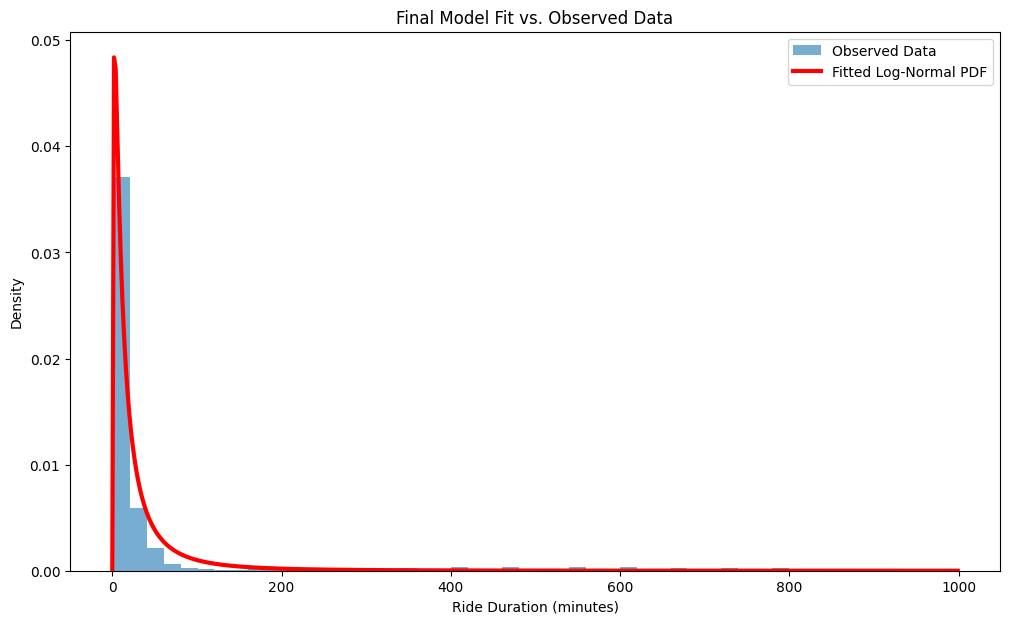

In [12]:
post = az.extract(idata)

mu_fit = post['mu'].mean().item()
sigma_fit = post['sigma'].mean().item()

plt.figure(figsize=(12, 7))
plt.hist(model_data, bins=50, density=True, alpha=0.6, label='Observed Data')

x_plot = np.linspace(0, model_data.max(), 500)
pdf_values = lognorm.pdf(x_plot, s=sigma_fit, scale=np.exp(mu_fit))

plt.plot(x_plot, pdf_values, 'r-', lw=3, label='Fitted Log-Normal PDF')
plt.title('Final Model Fit vs. Observed Data')
plt.xlabel('Ride Duration (minutes)')
plt.ylabel('Density')
plt.legend()
plt.show()

As a final note, the final parameters are very close to what was found manually, but this process of
creating a Bayesian model helped to remove some level of uncertainty, which is emphasized with the 
minor difference of the final "optimal" choices for mu and sigma.